In [2]:
import numpy as np
import matplotlib.pyplot as plt

In [3]:
# read in the raw CMB data from downloaded text file, converting it to a 2-D numpy array
directory = "C:\\Users\\daniel\\OneDrive - The University of Chicago\\Documents\\uchicago\\second year\\spring\\ASTR 29800\\"
file = "firas_monopole_spec_v1.txt"

with open(directory+file) as datafile:
    contents = datafile.readlines()
    datakey = ["frequency","spectrum","residual of spectrum","spectrum uncertainty","modeled galaxy spectrum"]
    rawdata = np.array(contents)
    rawdata = rawdata[np.flatnonzero(np.core.defchararray.find(rawdata,"#")==-1)]
    data = np.zeros((len(rawdata),5))
    for i,j in enumerate(rawdata):
        j = np.asarray(np.array(j.replace("\n","").split(" "))[np.array(j.replace("\n","").split(" "))!=""],dtype=float)
        data[i] = j

In [3]:
def mcmc_de(x0, logpdf = None, args = None, nsteps=10000):
    """
    MCMC sampler implementing the Goodman & Weare (2010) 
    affine-invariant algorithm 

    run for nminsteps and convergence specified by convergence_func is reached

    Parameters:
    ------------
    x - numpy array of floats of shape (nwalkers,ndim)
        containing initial x values of the chains
    logpdf - python function object
        ln(pdf) where pdf is the target pdf to sample
    args - list, list of arguments to pass logpdf functions (as logpdf(x, *args))
    nteps - int
        minimum number of MCMC steps (iterations) to make

    Returns:
    ---------
    chain - numpy array of shape (nwalkers*nsteps, ndim)
        x values of samples in the MCMC chains given that chain length is nsteps
    """
    
    x = x0
    nparams = np.size(x[:,0])
    ndim = np.size(x[0])
    gamma = 2.38/(ndim**0.5)
    fnow = np.apply_along_axis(logpdf, 1, x, *args)
    
    chain = np.copy(x).reshape(nparams, 1, np.size(x[0]))
    for nstep in range(nsteps):
        # creates shuffled indices array with unique elements and excluding the row number
        # guarentees two x[offset] are unique and differ from the row
        offsetarr = np.indices((nwalkers,nwalkers))[1]+np.indices((nwalkers,nwalkers))[0]+1
        offsetarr[offsetarr>nwalkers-1] = offsetarr[offsetarr>nwalkers-1]-nwalkers
        rng = np.random.default_rng()
        offsetarr = rng.permuted(offsetarr[:,:nwalkers-1],axis=1)
        xr1,xr2 = x[offsetarr[:,0]],x[offsetarr[:,1]]
        
        # add-able array of random numbers for each walker with b=0.001
        epsilon = np.tile(np.random.uniform(-0.001,0.001,size=(1,nwalkers)),(ndim,1)).transpose()
        
        xtry = x + gamma*(xr2-xr1) + epsilon
        
        ftry = np.apply_along_axis(logpdf, 1, xtry, *args)
        
        # uses array filtering by condition to change x and fnow
        cond1 = (ftry >= fnow)
        x[cond1] = xtry[cond1]
        fnow[cond1] = ftry[cond1]
        u = np.random.uniform(0,1,nwalkers)
        
        cond2 = np.log(u) < (ftry - fnow)
        x[np.invert(cond1) & (cond2)] = xtry[np.invert(cond1) & (cond2)]
        fnow[np.invert(cond1) & (cond2)] = ftry[np.invert(cond1) & (cond2)]
        
        chain = np.hstack((chain, x.reshape(nparams, 1, ndim)))
    return chain

In [4]:
def bose_einstein(v,T,mu,h=6.63e-34,k=1.38e-23,c=3e8):
    '''
    v: frequency (Hz)
    T: temperature (K)
    mu: =0 if blackbody (unitless)
    h: Planck's constant (J/s)
    k: Boltzmann constant (J/K)
    c: speed of light (m/s)
    
    returns
    spectral radiance (W*sr^-1*m^-2*Hz^-1)
    '''
    return 2*h*(v**3)/((c**2)*(np.exp(mu+(h*v)/(k*T))-1))

In [5]:
def ln_likelihood(x0, *args):
    '''
    v: frequency (Hz)
    I: intensity (W*sr^-1*m^-2*Hz^-1)
    sigI: intensity uncertainty (W*sr^-1*m^-2*Hz^-1)
    x0: contains both T temperature (K) and mu =0 if blackbody (unitless)
    '''
    T,mu = x0
    v,I,sigI = args
    deltmu = I-bose_einstein(v=v,T=T,mu=mu)

    return -0.5*(np.sum((deltmu**2)/sigI**2)+np.sum(np.log(2*np.pi*sigI**2)))

def ln_prior(x0, *args):
    T,mu = x0
    v,I,sigI = args
    
    if ((T<1) or (T>5) or (mu<-0.1) or (mu>0.1)):
        return -np.inf
    else:
        return 0.
    
def ln_posterior(x0, *args):
    pres = ln_prior(x0, *args)
    if pres > -np.inf:
        return ln_likelihood(x0, *args) + pres
    else:
        return -np.inf

In [6]:
# input frequency of 1/cm must be converted to Hz
# to convert, multiply 1/cm by speed of light in cm/s to get to unit of 1/s (Hz)
v = data.T[0]*3e10
# final data in MJy/sr units = 1e6*1e-26 W*sr^-1*m^-2*Hz^-1
# to make consistent with output, must divide by 1e6*1e-26 = 1e20
I = data.T[1]/1e20
# the same applies to the uncertainty, but with 1e3*1e-26 = 1e23
sigI = data.T[3]/1e23

args = v,I,sigI



ndim, nwalkers, nsteps = 2, 100, 10000

# initialize walkers around best fit parameter values
best_fit = np.array([2.729,0])
best_fit = np.tile(best_fit,(nwalkers,1))
for d in range(ndim): 
    # generate Gaussian random numbers 
    # 0.05 is a small dispersion around the mean. The exact value does not matter
    best_fit[:,d] = best_fit[:,d]+0.005*np.random.normal(size=nwalkers)

chain = mcmc_de(best_fit, logpdf = ln_posterior, args = args, nsteps=nsteps)

In [7]:
from matplotlib.colors import LogNorm
from matplotlib.patches import Ellipse
import matplotlib.transforms as transforms

# https://matplotlib.org/stable/gallery/statistics/confidence_ellipse.html
def confidence_ellipse(x, y, ax, n_std=3.0, facecolor='none', **kwargs):
    """
    Create a plot of the covariance confidence ellipse of *x* and *y*.

    Parameters
    ----------
    x, y : array-like, shape (n, )
        Input data.

    ax : matplotlib.axes.Axes
        The axes object to draw the ellipse into.

    n_std : float
        The number of standard deviations to determine the ellipse's radiuses.

    **kwargs
        Forwarded to `~matplotlib.patches.Ellipse`

    Returns
    -------
    matplotlib.patches.Ellipse
    """
    if x.size != y.size:
        raise ValueError("x and y must be the same size")

    xyfilter = (x>np.percentile(x,1))&(x<np.percentile(x,99))&(y>np.percentile(y,1))&(y<np.percentile(y,99))
    cov = np.cov(x[xyfilter], y[xyfilter])
    pearson = cov[0, 1]/np.sqrt(cov[0, 0] * cov[1, 1])
    # Using a special case to obtain the eigenvalues of this
    # two-dimensional dataset.
    ell_radius_x = np.sqrt(1 + pearson)
    ell_radius_y = np.sqrt(1 - pearson)
    ellipse = Ellipse((0, 0), width=ell_radius_x * 2, height=ell_radius_y * 2,
                      facecolor=facecolor, **kwargs)

    # Calculating the standard deviation of x from
    # the squareroot of the variance and multiplying
    # with the given number of standard deviations.
    scale_x = np.sqrt(cov[0, 0]) * n_std
    mean_x = np.mean(x)

    # calculating the standard deviation of y ...
    scale_y = np.sqrt(cov[1, 1]) * n_std
    mean_y = np.mean(y)

    transf = transforms.Affine2D() \
        .rotate_deg(45) \
        .scale(scale_x, scale_y) \
        .translate(mean_x, mean_y)

    ellipse.set_transform(transf + ax.transData)
    return ax.add_patch(ellipse)

def plot_scatter_conf(x,y,xlim,ylim,xax,yax,title):
    fig, ax_nstd = plt.subplots(figsize=(9, 9))
    fig.patch.set_facecolor('lightgrey')
    ax_nstd.hist2d(x, y, bins=(100,100), cmap="RdPu", range=[xlim,ylim], norm=LogNorm())
    confidence_ellipse(x, y, ax_nstd, n_std=1,label=r'$1\sigma$', edgecolor='indigo', lw=2)
    confidence_ellipse(x, y, ax_nstd, n_std=2,label=r'$2\sigma$', edgecolor='blue', lw=2)
    confidence_ellipse(x, y, ax_nstd, n_std=3,label=r'$3\sigma$', edgecolor='cornflowerblue', lw=2)
    xmean,ymean = np.mean(x),np.mean(y)
    ax_nstd.scatter(xmean,ymean,color="peru",marker="X")
    ax_nstd.annotate(f'mean = ({xmean:.6E} , {ymean:.6E})', xy=(xmean,ymean), color="peru", 
                     bbox=dict(fc="white"),
                     xytext=(xmean+(xlim[1]-xlim[0])*0.1,ymean-(ylim[1]-ylim[0])*0.2),
                     arrowprops=dict(arrowstyle="-",color="peru"))
    ax_nstd.grid(True,linestyle="--")
    ax_nstd.legend(loc="upper left")
    plt.xlabel(xax)
    plt.ylabel(yax)
    plt.title(title)
    plt.show()

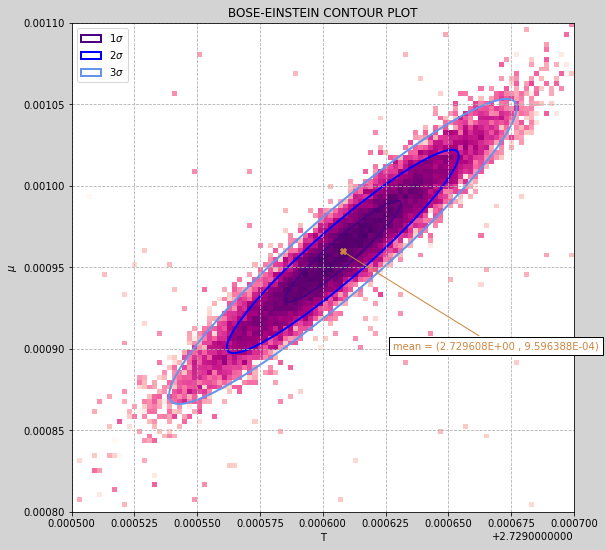

In [8]:
x = chain[:,:,0].flatten()
y = chain[:,:,1].flatten()
plot_scatter_conf(x,y,[2.7295,2.7297],[0.00080,0.0011],"T","$\mu$","BOSE-EINSTEIN CONTOUR PLOT")

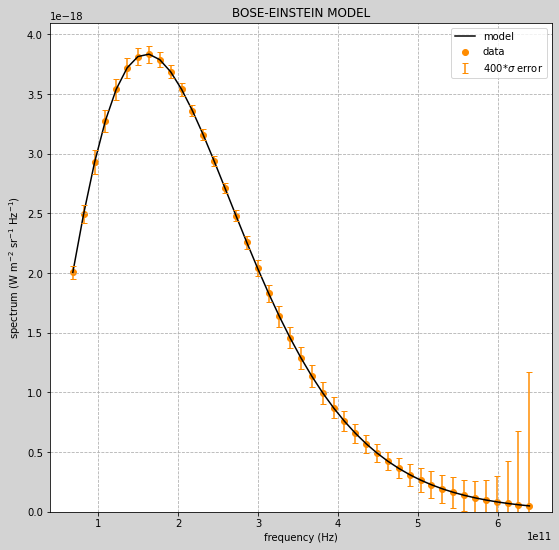

In [9]:
T,mu = np.mean(x),np.mean(y)

fig, ax = plt.subplots(figsize=(9, 9))
fig.patch.set_facecolor('lightgrey')
ax.plot(v,bose_einstein(v,T,mu),color="black",label="model")
ax.scatter(v,I,label="data",color="darkorange")
ax.errorbar(v,I,yerr=sigI*400,fmt="none",ecolor="darkorange",capsize=3,label="400*$\sigma$ error")
ax.grid(True,linestyle="--")
plt.ylim(0,4.1e-18)
plt.xlabel("frequency (Hz)")
plt.ylabel("spectrum (W m$^{-2}$ sr$^{-1}$ Hz$^{-1}$)")
plt.title("BOSE-EINSTEIN MODEL")
plt.legend()
plt.show()

---

In [10]:
from scipy.integrate import quad

# H0 must be converted to SI units
# 1Mpc = 3.0857e22m, 1km=1000m
# 67.4 km/s/Mpc*1000/3.0857e22 = 4.578e-18

def steady_state(tau,kappa,v,T,mu,h=6.63e-34,k=1.38e-23,c=3e8,H0=4.578e-18):
    '''
    tau: (s)
    kappa: optical depth (1/s)
    v: frequency (Hz)
    T: temperature (K)
    mu: =0 if blackbody (unitless)
    h: Planck's constant (J/s)
    k: Boltzmann constant (J/K)
    c: speed of light (m/s)
    H0: Hubble's constant (km/s/Mpc -> 1/s)
    
    returns
    spectral radiance (W*sr^-1*m^-2*Hz^-1)
    '''
    # 2*h*(v**3)/((c**2)*(np.exp(mu+(h*v)/(k*T))-1))
    conversion = 1/1000*3.0857e22
    vnew = v*np.exp(H0*tau)
    pspectrum = bose_einstein(vnew,T,mu)
    integral = kappa*np.exp(-1*(3*H0+kappa)*tau)*pspectrum
    return integral

def integrate_steady_state(kappa,v,T,mu):
    '''
    tau is ommitted in this function, as it is the variable integrated over
    kappa: optical depth (1/s)
    v: frequency (Hz)
    T: temperature (K)
    mu: =0 if blackbody (unitless)
    
    returns
    spectral radiance (W*sr^-1*m^-2*Hz^-1)
    '''
    conversion = 1/1000*3.0857e22
    integrations = []
    for i in range(len(v)):
        sargs = kappa,v[i],T,mu
        integral,error = quad(steady_state,0,2.184e17,args=sargs,epsabs=1e-20)
        integrations.append(integral)
    return np.array(integrations)

In [11]:
def ln_likelihood_s(x0, *args):
    '''
    v: frequency (Hz)
    I: intensity (W*sr^-1*m^-2*Hz^-1)
    sigI: intensity uncertainty (W*sr^-1*m^-2*Hz^-1)
    x0: contains both T temperature (K) and mu =0 if blackbody (unitless)
    '''
    T,kappa = x0
    v,mu,I,sigI = args
    deltmu = I-integrate_steady_state(kappa,v,T,mu)

    return -0.5*(np.sum((deltmu**2)/sigI**2)+np.sum(np.log(2*np.pi*sigI**2)))

def ln_prior_s(x0, *args):
    T,kappa = x0
    v,mu,I,sigI = args
    
    if ((T<1) or (T>5) or (kappa<4.578e-18*1e-5) or (kappa>4.578e-18*1e5)):
        return -np.inf
    else:
        return 0.
    
def ln_posterior_s(x0, *args):
    pres = ln_prior_s(x0, *args)
    if pres > -np.inf:
        return ln_likelihood_s(x0, *args) + pres
    else:
        return -np.inf

In [12]:
import emcee

# input frequency of 1/cm must be converted to Hz
# to convert, multiply 1/cm by speed of light in cm/s to get to unit of 1/s (Hz)
v = data.T[0]*3e10
# final data in MJy/sr units = 1e6*1e-26 W*sr^-1*m^-2*Hz^-1
# to make consistent with output, must divide by 1e6*1e-26 = 1e20
I = data.T[1]/1e20
# the same applies to the uncertainty, but with 1e3*1e-26 = 1e23
sigI = data.T[3]/1e23
# mu can be assumed to be 0 for this model (blackbody)
mu = 0

args = v,mu,I,sigI



ndim, nwalkers, nsteps = 2, 100, 10000

# initialize walkers around best fit parameter values
# in paper, T is quoted as 2.736K and kappa is suggested to be a multiple of H0, will go with 3*H0
best_fit = np.array([2.736,3*4.578e-18])
best_fit = np.tile(best_fit,(nwalkers,1))
# for d in range(ndim): 
#     # generate Gaussian random numbers 
#     # 0.05 is a small dispersion around the mean. The exact value does not matter
#     best_fit[:,d] = best_fit[:,d]+1e-18*np.random.normal(size=nwalkers)

best_fit[:,0] = best_fit[:,0]+0.001*np.random.normal(size=nwalkers)
best_fit[:,1] = best_fit[:,1]+1e-18*np.random.normal(size=nwalkers)

    
sampler = emcee.EnsembleSampler(nwalkers, ndim, ln_posterior_s, args=args)
sampler.run_mcmc(best_fit, nsteps)

# get chain
chain = np.array(sampler.chain)
    
#chain = mcmc_de(best_fit, logpdf = ln_posterior_s, args = args, nsteps=nsteps)

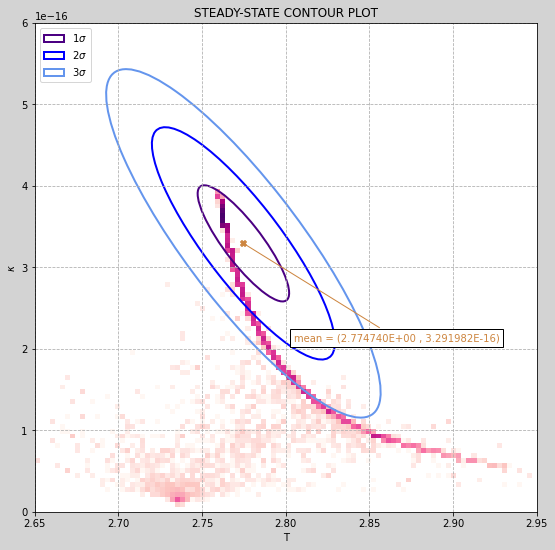

In [31]:
x = chain[:,:,0].flatten()
y = chain[:,:,1].flatten()
plot_scatter_conf(x,y,[2.65,2.95],[0,6e-16],"T","$\kappa$","STEADY-STATE CONTOUR PLOT")

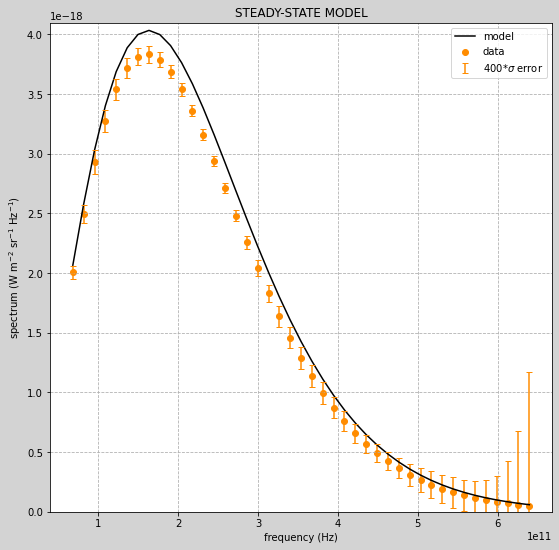

In [36]:
T,mu = np.mean(x),np.mean(y)

fig, ax = plt.subplots(figsize=(9, 9))
fig.patch.set_facecolor('lightgrey')
ax.plot(v,bose_einstein(v,T,mu),color="black",label="model")
ax.scatter(v,I,label="data",color="darkorange")
ax.errorbar(v,I,yerr=sigI*400,fmt="none",ecolor="darkorange",capsize=3,label="400*$\sigma$ error")
ax.grid(True,linestyle="--")
plt.ylim(0,4.1e-18)
plt.xlabel("frequency (Hz)")
plt.ylabel("spectrum (W m$^{-2}$ sr$^{-1}$ Hz$^{-1}$)")
plt.title("STEADY-STATE MODEL")
plt.legend()
plt.show()

In [7]:
v = data.T[0]*3e10

(6.63e-34*v)/(1.38e-23*2.729)

array([ 1.19888636,  1.43655105,  1.67949719,  1.91716188,  2.15482658,
        2.39777271,  2.63543741,  2.87838355,  3.11604824,  3.35371294,
        3.59665907,  3.83432377,  4.07198847,  4.3149346 ,  4.5525993 ,
        4.79554543,  5.03321013,  5.27087482,  5.51382096,  5.75148565,
        5.98915035,  6.23209648,  6.46976118,  6.71270731,  6.95037201,
        7.18803671,  7.43098284,  7.66864754,  7.90631223,  8.14925837,
        8.38692306,  8.6298692 ,  8.8675339 ,  9.10519859,  9.34814473,
        9.58580942,  9.82875556, 10.06642025, 10.30408495, 10.54703108,
       10.78469578, 11.02236048, 11.26530661])